         Maturity InstType  Market.Mid  DaysToMaturity  discount factor  \
Tenor                                                                     
3MO    2021-01-09     CASH     0.22538            92.0         0.999424   
6MO    2021-03-17   FUTURE    99.72500           159.0         0.998992   
9MO    2021-06-16   FUTURE    99.78500           250.0         0.998299   
12MO   2021-09-15   FUTURE    99.80000           341.0         0.997756   
15MO   2021-12-15   FUTURE    99.80000           432.0         0.997252   
18MO   2022-03-16   FUTURE    99.78000           523.0         0.996748   
21MO   2022-06-15   FUTURE    99.80000           614.0         0.996194   
2Y     2022-10-07     SWAP     0.21815           728.0         0.995545   
3Y     2023-10-09     SWAP     0.23010          1095.0         0.993152   
4Y     2024-10-09     SWAP     0.26820          1461.0         0.990419   
5Y     2025-10-09     SWAP     0.32795          1826.0         0.986307   
6Y     2026-10-09     SWA

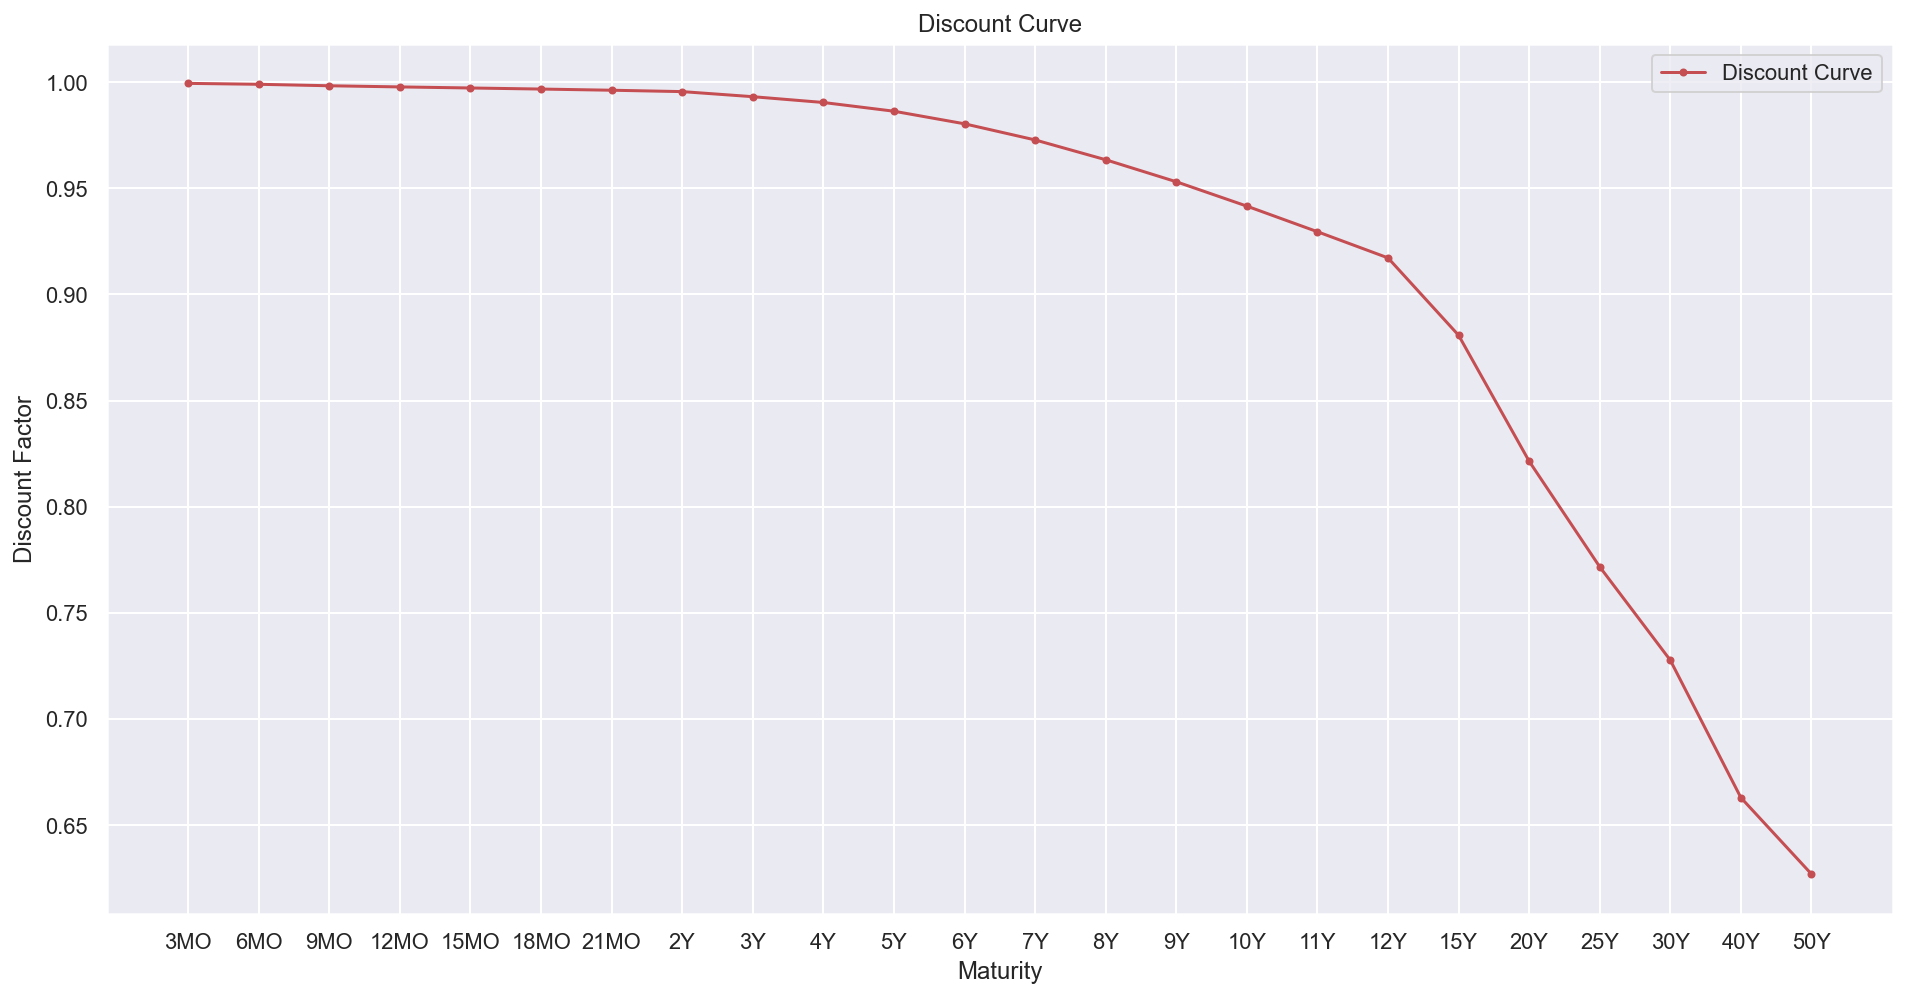

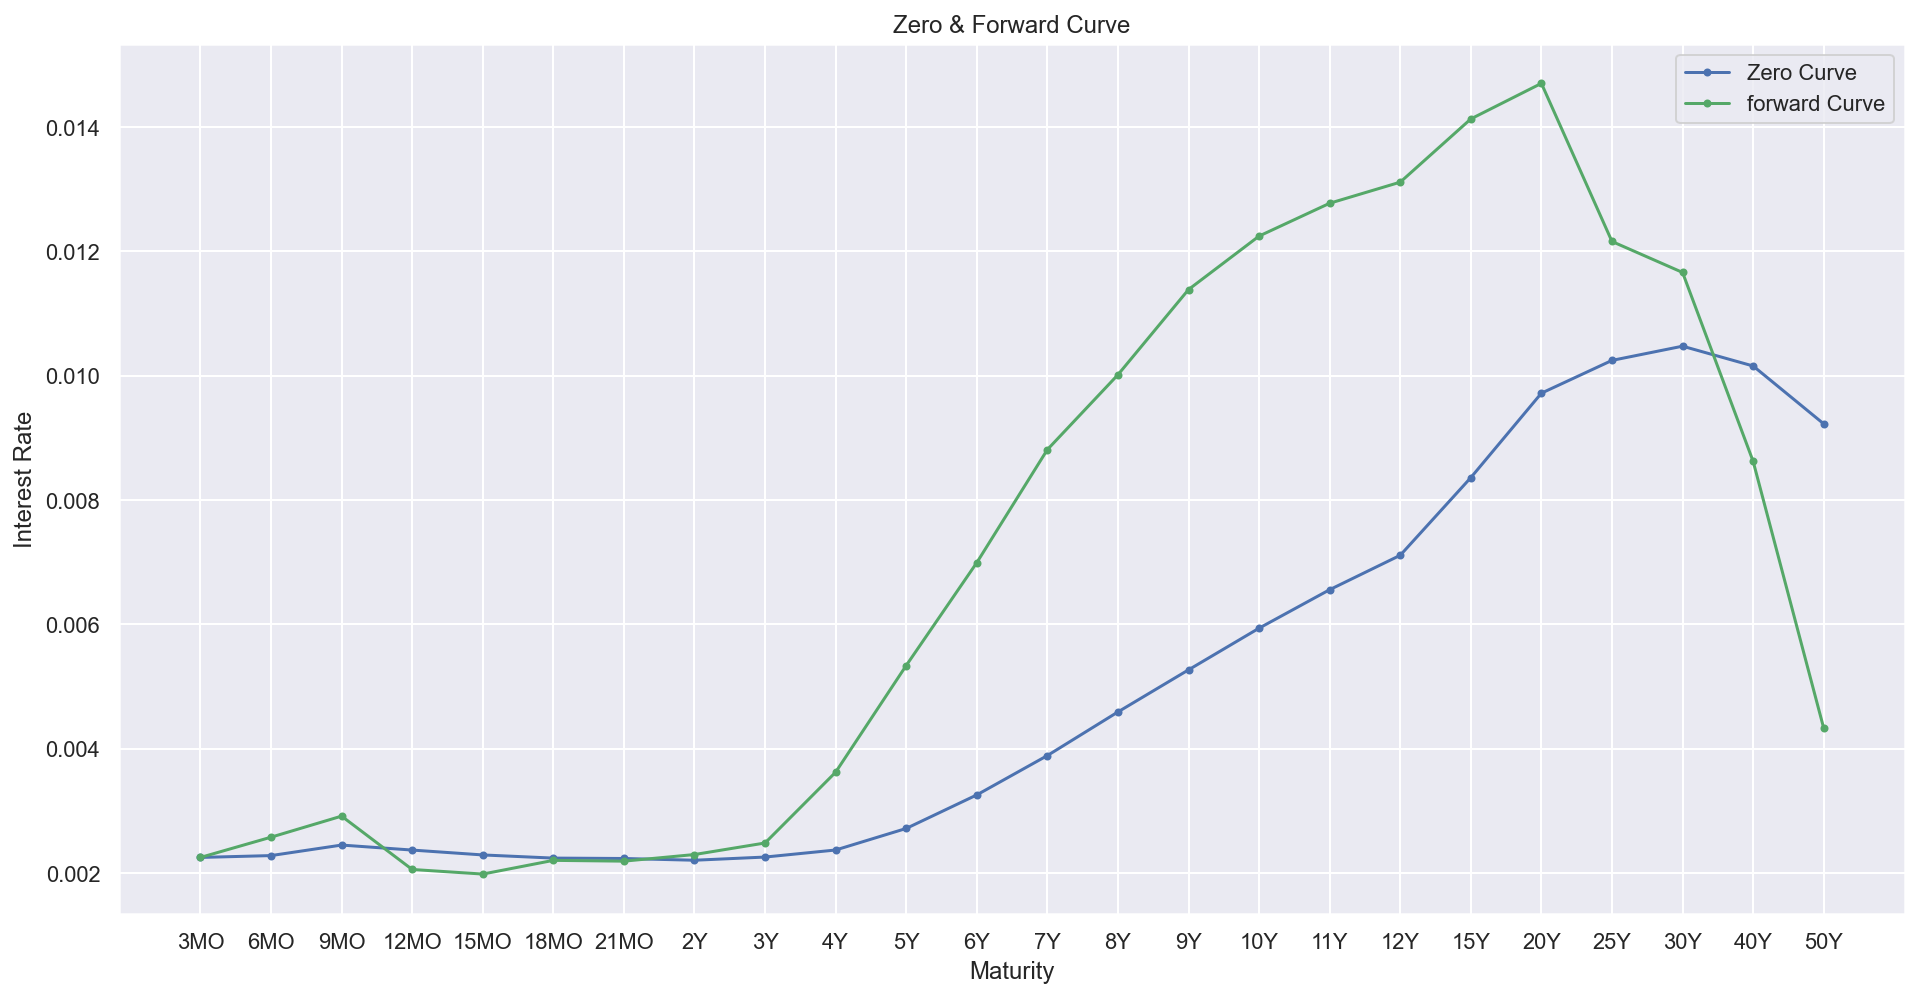

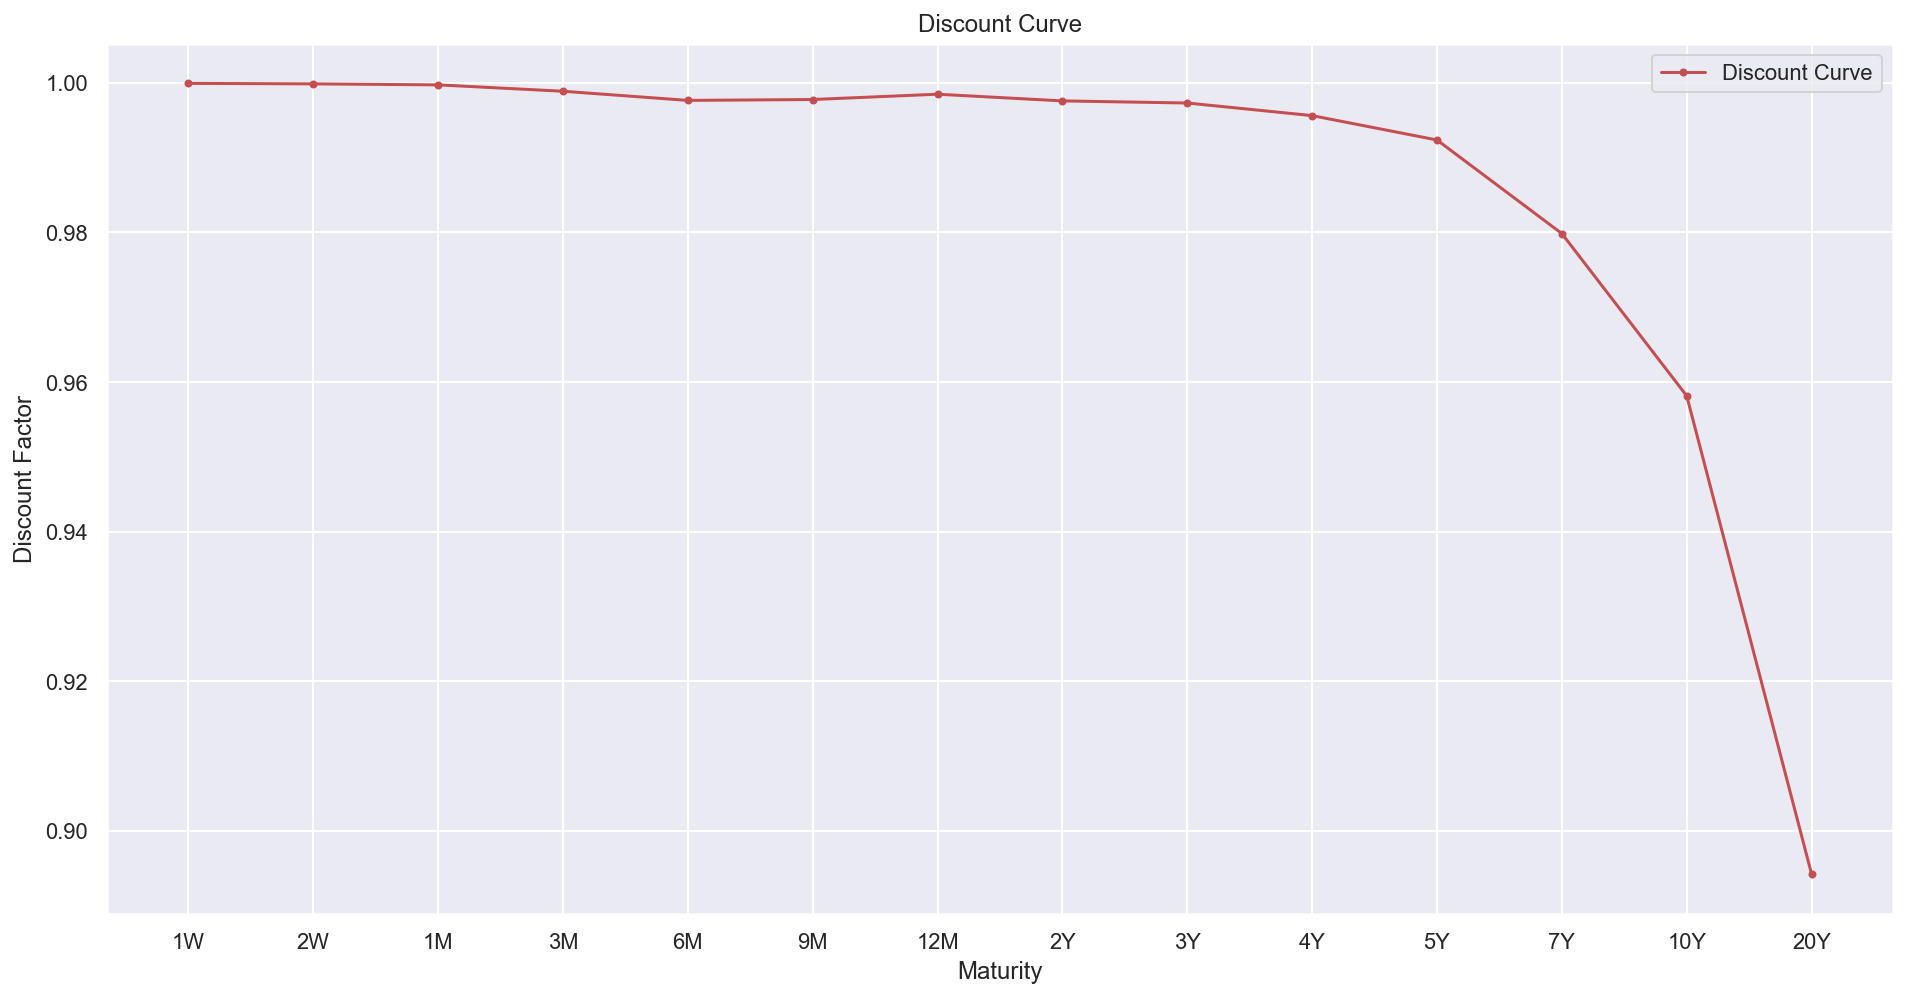

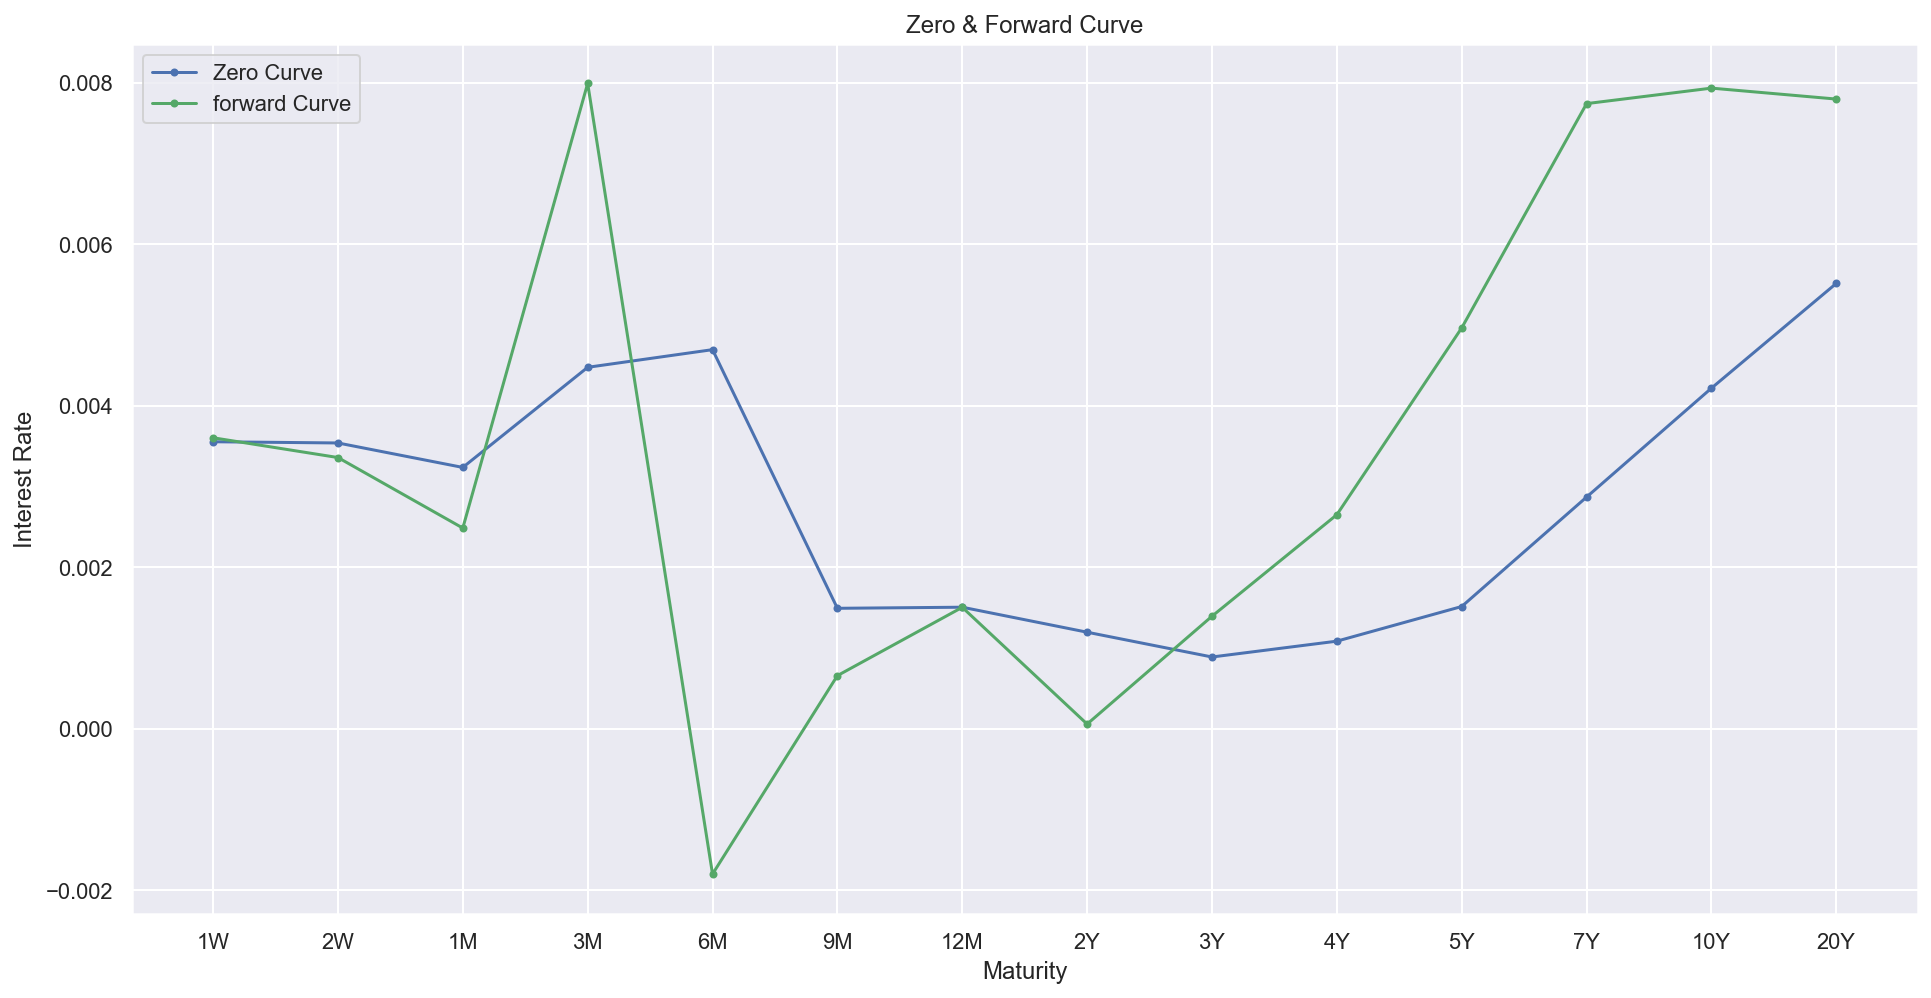

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import QuantExt as qe
import QuantLib as ql
import xlwings as xw

def GET_QUOTE(today, ticker):
    xw.App(visible=False)
    wb = xw.Book('./data/FX_CURVE.xlsx')
    
    if ticker =='USD':   
        sht = wb.sheets('USDIRS')
        curve = sht.range('A1:D25').options(pd.DataFrame).value
    elif ticker == 'KRW':
        sht = wb.sheets('KRWCCS')
        curve = sht.range('A1:D15').options(pd.DataFrame).value
    wb.close()
    
    #잔존일수 칼럼 추가
    curve['DaysToMaturity'] = np.nan
    #to_datetime : dtype을 datetime[ns]로 바꾸기
    # .dt.date : 아예 datetime(y,m,d) 식으로 바꾸기
    curve['Maturity'] = pd.to_datetime(curve['Maturity']).dt.date
    
    for tenor in curve.index:
        curve.loc[tenor, 'DaysToMaturity'] = (curve.loc[tenor, 'Maturity'] - today).days
    
    return curve

#미국 스왑금리 커브
def USDIRS_CURVE(today, quote):
    # 금리 기간구조를 만들때, 여러 helper를 이용해야 함
    # 단기준거금리 / 선물내재금리 / 스왑금리
    # CASH , FUTURE, SWAP 나누기
    depo = quote[quote['InstType'] == 'CASH']  #단기금리
    futures = quote[quote['InstType'] == 'FUTURE'] #중기금리
    swap = quote[quote['InstType'] == 'SWAP'] #장기금리

    #전역으로 먼저 평가일자 선언
    todays_date = qe.Date(today.day, today.month, today.year)
    qe.Settings.instance().evaluationDate = todays_date
    
    #Convention
    calendar = qe.UnitedStates()
    dayCounter = qe.Actual360() #1년을 360일로
    convention = ql.ModifiedFollowing
    settlementDays = 2  #정산일자 / 스왑계약, 거래일로부터 2일 뒤 효력
    # 한국은 보통 1일
    frequency = ql.Semiannual
    
    #Deposit rate helper
    depositHelpers = [qe.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                         ql.Period(int(day), ql.Days),
                                         settlementDays,
                                         calendar,
                                         convention,
                                         False,
                                         dayCounter)
                    for day,rate in zip(depo['DaysToMaturity'], depo['Market.Mid'])]
    
    #Futures Rate helper
    futuresHelpers = []
    for i, price in enumerate(futures['Market.Mid']):
        iborStartDate = ql.Date(futures['Maturity'][i].day,
                               futures['Maturity'][i].month,
                               futures['Maturity'][i].year)
        futuresHelper = ql.FuturesRateHelper(price,
                                            iborStartDate, #각 선물의 만기
                                            3,
                                            calendar,
                                            convention,
                                            False,
                                            dayCounter)
        futuresHelpers.append(futuresHelper)
    
    #Swap Rate Helper
    swapHelpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                    ql.Period(int(day), ql.Days), #잔존일수
                                    calendar,
                                    frequency, convention, dayCounter,
                                    ql.USDLibor(ql.Period(3, ql.Months))) #준거금리... 껍데기인 유라이보 3개월.
                                   #아무거나 3개월짜리 지정..
                  for day, rate in zip(swap['DaysToMaturity'], swap['Market.Mid'])]
    
    
    helpers = depositHelpers + futuresHelpers + swapHelpers
    depoFuturesSwapCurve = ql.PiecewiseLinearZero(todays_date, helpers, dayCounter)
    
    return depoFuturesSwapCurve #여기까지만 있어도 파생상품 Pricing은 가능
    #금리커브가 필요한 이유는 할인커브를 만들기 위함임!
    

def KRWCCS_CURVE(today, quote):
    depo = quote[quote['InstType'] == 'CASH']  
    swap = quote[quote['InstType'] == 'SWAP'] 
    
    todays_date = qe.Date(today.day, today.month, today.year)
    qe.Settings.instance().evaluationDate = todays_date   
    
    calendar = qe.SouthKorea()
    dayCounter = qe.Actual365Fixed() #Act/365 : 1년은 365일로 가정
    #이자계산은 실제 일수대로 하고 분모인 1년을 365로 하겟다.
    convention = ql.ModifiedFollowing
    settlementDays = 1
    # 금리결정일과 이자정산일의 차이
    # 거래일과 효력발생일의 차이 
    frequency = ql.Semiannual
    
    #Deposit rate helper
    depositHelpers = [qe.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                         ql.Period(int(day), ql.Days),
                                         settlementDays,
                                         calendar,
                                         convention,
                                         False,
                                         dayCounter)
                    for day,rate in zip(depo['DaysToMaturity'], depo['Market.Mid'])]
    
    #Swap Rate Helper
    swapHelpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                    ql.Period(int(day), ql.Days), #잔존일수
                                    calendar,
                                    frequency, convention, dayCounter,
                                    ql.USDLibor(ql.Period(3, ql.Months))) #준거금리
                  for day, rate in zip(swap['DaysToMaturity'], swap['Market.Mid'])]
    
    helpers = depositHelpers + swapHelpers
    depoFuturesSwapCurve = ql.PiecewiseLinearZero(todays_date, helpers, dayCounter)
    
    return depoFuturesSwapCurve

def DISCOUNT_FACTOR(date, curve):
    #퀀트립 데이트로 변환
    date = qe.Date(date.day, date.month, date.year)
    return curve.discount(date) #특정날짜의 할인계수

def ZERO_RATE(date, curve):
    date = qe.Date(date.day, date.month, date.year)

    dayCounter = qe.Actual360()
    compounding = qe.Compounded
    frequency = qe.Continuous   #제로금리 구할 때에는 연속복리 가정
    
    zero_rate = curve.zeroRate(date, dayCounter, compounding, frequency).rate()
    return zero_rate  #특정 조건을 만족하는 제로금리

def FORWARD_RATE(date, curve):
    date = qe.Date(date.day, date.month, date.year)
    
    dayCounter = qe.Actual360()
    compounding = qe.Compounded
    frequency = qe.Continuous
    
    #시작날짜와 끝날짜 필요
    forward_rate = curve.forwardRate(date,  #시작-끝 같은 날짜로
                                    date,  #구간이 줄어드므로
                                    dayCounter, #딱 이 date에 선도금리가 얼마냐
                                     compounding, #근사가 됨
                                     frequency).rate()
    return forward_rate

if __name__ == '__main__':
    date = datetime.date(2020,10,9)
    ticker1 = 'USD'
    ticker2 = 'KRW'
    
    quote1 = GET_QUOTE(date, ticker1) #미국금리 데이터
    quote2 = GET_QUOTE(date, ticker2) #원화통화스왑 금리 데이터 
    
    usd_curve = USDIRS_CURVE(date, quote1)
    krw_curve = KRWCCS_CURVE(date, quote2)
    
    quote1['discount factor'] = np.nan
    quote1['zero rate'] = np.nan
    quote1['forward rate'] = np.nan
    
    for tenor, date in zip(quote1.index, quote1['Maturity']):
        quote1.loc[tenor, 'discount factor'] = DISCOUNT_FACTOR(date, usd_curve)
        quote1.loc[tenor, 'zero rate'] = ZERO_RATE(date, usd_curve)
        quote1.loc[tenor, 'forward rate'] = FORWARD_RATE(date, usd_curve)
        
    print(quote1)    
    
    #Plot the result
    plt.figure(figsize=(16,8))
    plt.plot(quote1['discount factor'], 'r.-', label='Discount Curve')
    plt.title('Discount Curve', loc='center')
    plt.legend()
    plt.xlabel('Maturity')
    plt.ylabel('Discount Factor')
    
    # zero_rate와 forward_rate는 단위가 같아서 한번에 그린다
    plt.figure(figsize=(16,8))
    plt.plot(quote1['zero rate'], 'b.-', label='Zero Curve')
    plt.plot(quote1['forward rate'], 'g.-', label='forward Curve')
    plt.title('Zero & Forward Curve', loc='center')
    plt.legend()
    plt.xlabel('Maturity')
    plt.ylabel('Interest Rate')
    
    
    quote2['discount factor'] = np.nan
    quote2['zero rate'] = np.nan
    quote2['forward rate'] = np.nan
    
    for tenor, date in zip(quote2.index, quote2['Maturity']):
        quote2.loc[tenor, 'discount factor'] = DISCOUNT_FACTOR(date, krw_curve)
        quote2.loc[tenor, 'zero rate'] = ZERO_RATE(date, krw_curve)
        quote2.loc[tenor, 'forward rate'] = FORWARD_RATE(date, krw_curve)
        
    print(quote2)  
    #Plot the result
    plt.figure(figsize=(16,8))
    plt.plot(quote2['discount factor'], 'r.-', label='Discount Curve')
    plt.title('Discount Curve', loc='center')
    plt.legend()
    plt.xlabel('Maturity')
    plt.ylabel('Discount Factor')
    
    # zero_rate와 forward_rate는 단위가 같아서 한번에 그린다
    plt.figure(figsize=(16,8))
    plt.plot(quote2['zero rate'], 'b.-', label='Zero Curve')
    plt.plot(quote2['forward rate'], 'g.-', label='forward Curve')
    plt.title('Zero & Forward Curve', loc='center')
    plt.legend()
    plt.xlabel('Maturity')
    plt.ylabel('Interest Rate')
    
    plt.show()